# Testing CircuitQ

In [1]:
import circuitq as cq

import numpy as np
import networkx as nx
import scqubits as sc
import matplotlib.pyplot as plt

## Test 0: LC-Circuit
#### Circuit

In [2]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'L');

#### Symbolic Hamiltonian

In [3]:
circuit = cq.CircuitQ(graph)
circuit.h

\Phi_{1}**2/(2*L_{010}) + 0.5*q_{1}**2/C_{01}

#### Diagonalization

In [4]:
h_num = circuit.get_numerical_hamiltonian(200)
eigv, eigs = circuit.get_eigensystem()

In [5]:
type(h_num)

scipy.sparse.csr.csr_matrix

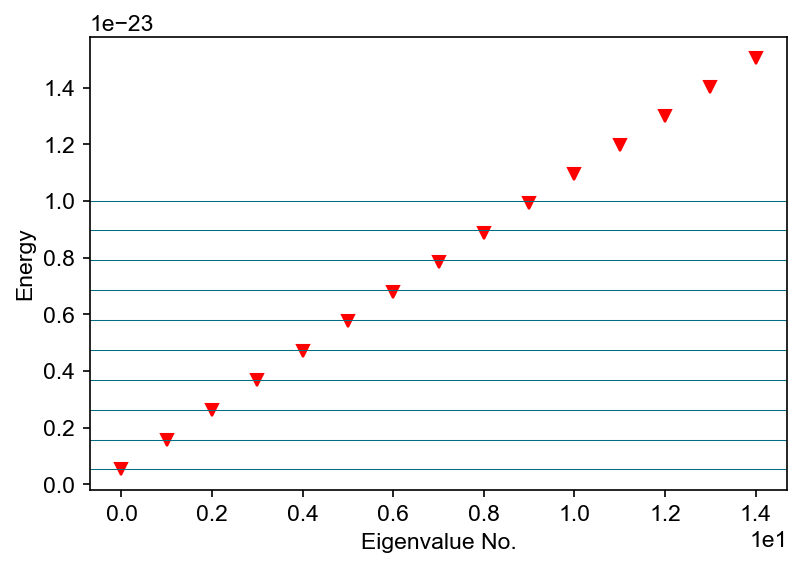

In [6]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(15), eigv[:15], 'rv')
omega = 1/np.sqrt(circuit.c_v["L"]*circuit.c_v["C"])
for n in range(10):
    plt.axhline(eigv[0]+n*circuit.hbar*omega, lw=0.5)
plt.xlabel("Eigenvalue No.")
plt.ylabel("Energy")
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show() 

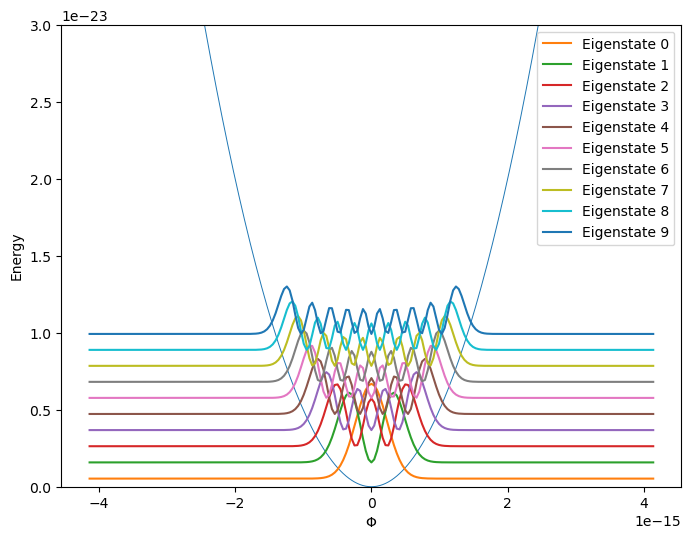

In [7]:
plt.style.use('default')
plt.figure(figsize=(8,6))
def potential(phi):
    return phi**2/(2*circuit.c_v["L"])
plt.plot(circuit.flux_list, potential(circuit.flux_list), lw=0.7)
for n in range(10):
    plt.plot(circuit.flux_list, 
            eigv[n]+(abs(eigs[:,n])**2*(max(circuit.flux_list)**2/(2*circuit.c_v["L"]))),
            label="Eigenstate " +str(n))
# plt.xlim(-10,10)
plt.ylim(0,3e-23)
plt.xlabel(r"$\Phi$")
plt.ylabel("Energy")
plt.legend()
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show()

## Test 1: Transmon
### CircuitQ
#### Circuit

In [8]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'J');

#### Symbolic Hamiltonian

In [9]:
circuit = cq.CircuitQ(graph, offset_nodes=[1])
circuit.h

-E_{J010}*cos(3.03853489761902e+15*\Phi_{1}) + 0.5*(q_{1} + qo_{1})**2/C_{01}

In [10]:
print(circuit.h_num)

None


#### Diagonalization

In [11]:
h_num = circuit.get_numerical_hamiltonian(401, grid_length=np.pi*circuit.phi_0)
eigv, eigs = circuit.get_eigensystem()

In [12]:
subs_dict = dict()
for n, parameter in enumerate(circuit.h_parameters):
    subs_dict[parameter] = circuit.parameter_values[n] 
print(circuit.h.subs(subs_dict))

5000000000000.0*q_{1}**2 - 6.41742491633892e-24*cos(3.03853489761902e+15*\Phi_{1})


### SCQubit

In [13]:
EJ = circuit.c_v["E"]
EC = circuit.c_v["E_C"]
transmon = sc.Transmon(EJ=EJ, EC=EC, ng=0, ncut=50)
esys = transmon.eigensys(evals_count=25)

### Compare

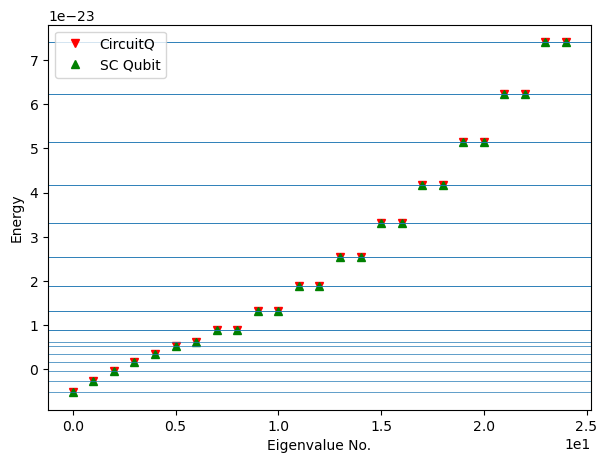

In [14]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(25), eigv[:25], 'rv', label="CircuitQ")
plt.plot(np.arange(25), esys[0][:25], 'g^', label="SC Qubit")
plt.legend()
plt.xlabel("Eigenvalue No.")
plt.ylabel("Energy")
for n in range(25):
    plt.axhline(esys[0][n], lw=0.5)
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show() 

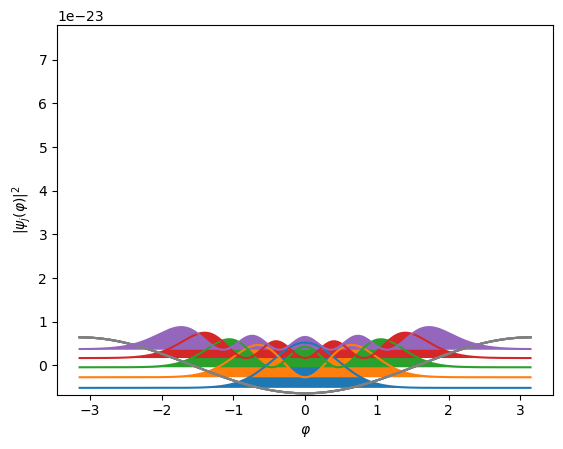

In [15]:
transmon.plot_phi_wavefunction(esys=esys, which=[0,1,2,3,4], mode='abs_sqr');

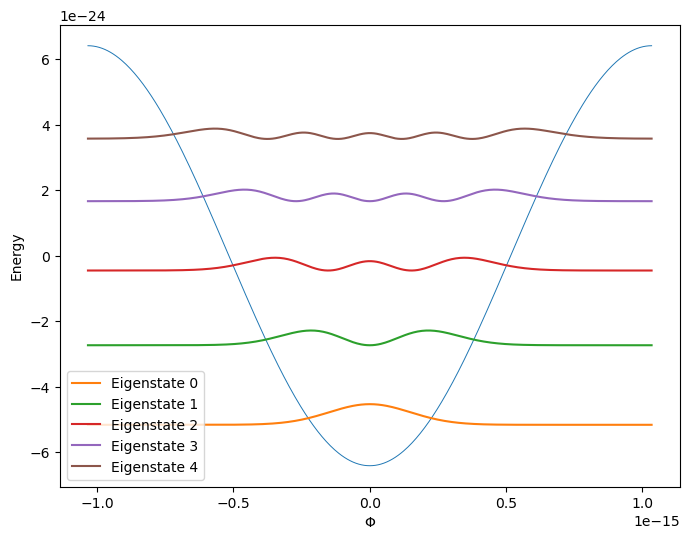

In [16]:
circuit.transform_charge_to_flux()
eigs = circuit.estates_in_phi_basis
n_states = 5
scaling = 10 * (eigv[n_states-1]-eigv[0]/n_states)
plt.style.use('default')
plt.figure(figsize=(8,6))
def potential(phi):
    return -circuit.c_v["E"]*np.cos(phi/circuit.phi_0)
plt.plot(circuit.flux_list, potential(circuit.flux_list), lw=0.7)
for n in range(n_states):
    plt.plot(circuit.flux_list, 
             eigv[n] + np.real(eigs[n]*np.conjugate(eigs[n]))*scaling ,label="Eigenstate " +str(n))
plt.legend()
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.xlabel(r"$\Phi$")
plt.ylabel("Energy")
plt.show()

## Test 2: Fluxonium
### CircuitQ
#### Circuit

In [17]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'J')
graph.add_edge(0,1, element = 'L');

#### Symbolic Hamiltonian

In [18]:
circuit = cq.CircuitQ(graph)
circuit.h

-E_{J010}*cos(3.03853489761902e+15*\Phi_{1}) + (\Phi_{1} + \tilde{\Phi}_{010})**2/(2*L_{010}) + 0.5*q_{1}**2/C_{01}

In [19]:
circuit.h_parameters

[C_{01}, E_{J010}, L_{010}, \tilde{\Phi}_{010}]

#### Diagonalization

In [20]:
EJ = circuit.c_v["E"]/2
phi_ext = np.pi*circuit.phi_0 
h_num = circuit.get_numerical_hamiltonian(401, parameter_values=[False, EJ, False, phi_ext ])
eigv, eigs = circuit.get_eigensystem()

### SCQubit

In [21]:
L = circuit.c_v["L"]
EC = circuit.c_v["E_C"]
EL = (circuit.phi_0**2) / L
fluxonium = sc.Fluxonium(EJ = EJ, EC = EC, EL = EL,
                         flux = phi_ext/(circuit.phi_0*2*np.pi), cutoff = 401)
esys = fluxonium.eigensys(evals_count=50)

### Compare

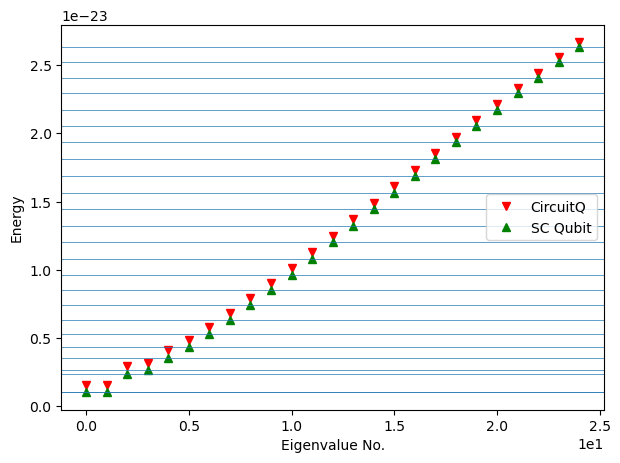

In [22]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(25), eigv[:25], 'rv', label="CircuitQ")
plt.plot(np.arange(25), esys[0][:25], 'g^', label="SC Qubit")
plt.legend()
plt.xlabel("Eigenvalue No.")
plt.ylabel("Energy")
for n in range(25):
    plt.axhline(esys[0][n], lw=0.5)
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show() 

In [23]:
circuit.evals

array([1.56622629e-24, 1.57903046e-24, 2.93306897e-24, 3.20155375e-24,
       4.10182169e-24, 4.89434391e-24, 5.84133838e-24, 6.84462131e-24,
       7.90450060e-24, 9.00680159e-24, 1.01432360e-23, 1.13064086e-23,
       1.24900801e-23, 1.36887507e-23, 1.48974886e-23, 1.61117896e-23,
       1.73274786e-23, 1.85406365e-23, 1.97475474e-23, 2.09446638e-23,
       2.21285905e-23, 2.32960915e-23, 2.44441256e-23, 2.55699230e-23,
       2.66711121e-23, 2.77459093e-23, 2.87933639e-23, 2.98136270e-23,
       3.08081631e-23, 3.17797942e-23])

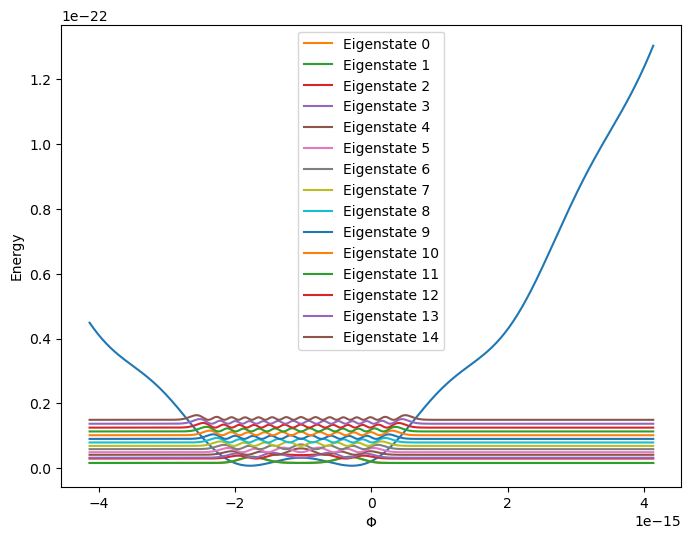

In [24]:
plt.style.use('default')
plt.figure(figsize=(8,6))
def potential(phi):
    return -EJ*np.cos(phi/circuit.phi_0) + (phi+ phi_ext)**2/(2*L)
plt.plot(circuit.flux_list, potential(circuit.flux_list), lw=1.5)
for n in range(15):
    plt.plot(circuit.flux_list, 
             eigv[n]+ abs(eigs[:,n])**2*(max(circuit.flux_list)**2/(2*circuit.c_v["L"])) 
             ,label="Eigenstate " +str(n))
plt.legend()
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.xlabel(r"$\Phi$")
plt.ylabel("Energy")
plt.show()

## Test 3: Flux Qubit
### CircuitQ
#### Circuit

In [25]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'J')
graph.add_edge(1,2, element = 'C')
graph.add_edge(1,2, element = 'J')
graph.add_edge(0,2, element = 'C')
graph.add_edge(0,2, element = 'J');

#### Symbolic Hamiltonian

In [26]:
circuit = cq.CircuitQ(graph)
circuit.h_parameters

[C_{01}, C_{02}, C_{12}, E_{J010}, E_{J020}, E_{J120}, \tilde{\Phi}_{120}]

In [27]:
circuit.h

-E_{J010}*cos(3.03853489761902e+15*\Phi_{1}) - E_{J020}*cos(3.03853489761902e+15*\Phi_{2}) - E_{J120}*cos(-3.03853489761902e+15*\Phi_{1} + 3.03853489761902e+15*\Phi_{2} + 3.03853489761902e+15*\tilde{\Phi}_{120}) + 0.5*q_{1}*(C_{12}*q_{2}/(C_{01}*C_{02} + C_{01}*C_{12} + C_{02}*C_{12}) + q_{1}*(C_{02} + C_{12})/(C_{01}*C_{02} + C_{01}*C_{12} + C_{02}*C_{12})) + 0.5*q_{2}*(C_{12}*q_{1}/(C_{01}*C_{02} + C_{01}*C_{12} + C_{02}*C_{12}) + q_{2}*(C_{01} + C_{12})/(C_{01}*C_{02} + C_{01}*C_{12} + C_{02}*C_{12}))

#### Diagonalization

In [28]:
dim = 50
EJ = 2.5*circuit.c_v["E"]
alpha = 0.7
C = circuit.c_v["C"]
phi_ext = np.pi*circuit.phi_0 
h_num = circuit.get_numerical_hamiltonian(dim, parameter_values=[C,C,alpha*C,EJ,EJ,alpha*EJ,phi_ext])
eigv, eigs = circuit.get_eigensystem(100)

In [29]:
subs_dict = dict()
for n, parameter in enumerate(circuit.h_parameters):
    subs_dict[parameter] = circuit.parameter_values[n] 
circuit.h.subs(subs_dict)

0.5*q_{1}*(7083333333333.33*q_{1} + 2916666666666.67*q_{2}) + 0.5*q_{2}*(2916666666666.67*q_{1} + 7083333333333.33*q_{2}) - 1.60435622908473e-23*cos(3.03853489761902e+15*\Phi_{1}) - 1.60435622908473e-23*cos(3.03853489761902e+15*\Phi_{2}) - 1.12304936035931e-23*cos(-3.03853489761902e+15*\Phi_{1} + 3.03853489761902e+15*\Phi_{2} + 3.14159265358979)

In [30]:
circuit.h_imp

1.0*C_{12}*q_{1}*q_{2}/(C_{01}*C_{02} + C_{01}*C_{12} + C_{02}*C_{12}) - E_{J010}*cos_{010} - E_{J020}*cos_{020} - E_{J120}*cos_{120} + 0.5*q^{q}_{1}*(C_{02} + C_{12})/(C_{01}*C_{02} + C_{01}*C_{12} + C_{02}*C_{12}) + 0.5*q^{q}_{2}*(C_{01} + C_{12})/(C_{01}*C_{02} + C_{01}*C_{12} + C_{02}*C_{12})

### SCQubit

In [31]:
EC = circuit.c_v["E_C"]
fluxqubit = sc.FluxQubit(EJ1 = EJ, EJ2 = EJ, EJ3 = alpha*EJ,
                         ECJ1 = EC, ECJ2 = EC, ECJ3 = EC/alpha,
                         ECg1 = 1e25, ECg2 = 1e25, ng1 = 0, ng2 = 0,
                         flux = phi_ext/(circuit.phi_0*2*np.pi), ncut = int(dim/2))
esys = fluxqubit.eigensys(evals_count=30)

### Compare

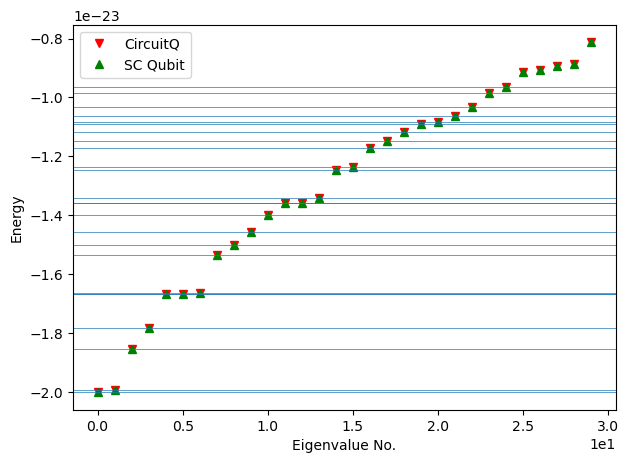

In [32]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(30), eigv[:30], 'rv', label="CircuitQ")
plt.plot(np.arange(30), esys[0][:30], 'g^', label="SC Qubit")
plt.legend()
plt.xlabel("Eigenvalue No.")
plt.ylabel("Energy")
for n in range(25):
    plt.axhline(esys[0][n], lw=0.5)
plt.ticklabel_format(style='scientific', scilimits=(0, 0))
plt.show() 

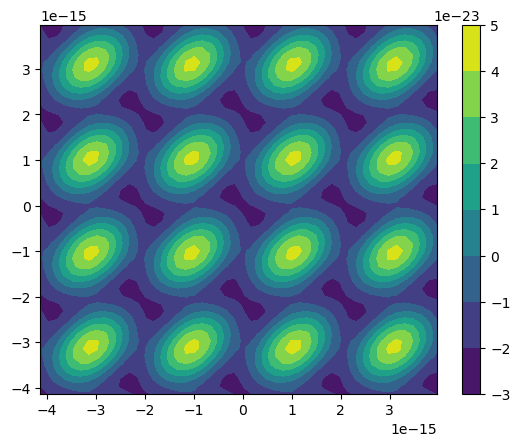

In [33]:
def potential(phi_1, phi_2, phi_ex):
    return (-EJ*np.cos(phi_1/circuit.phi_0) - EJ*np.cos(phi_2/circuit.phi_0) -
             alpha*EJ*np.cos((phi_2-phi_1+phi_ex)/circuit.phi_0) )
phis = np.arange(-4*np.pi*circuit.phi_0, 4*np.pi*circuit.phi_0, 8*np.pi*circuit.phi_0/dim)
potential_list = []
for phi_1 in phis:
    for phi_2 in phis:
        potential_list.append(potential(phi_1,phi_2,phi_ext))
plt.style.use('default')
plt.contourf(phis, phis, np.array(potential_list).reshape(dim,dim))
plt.colorbar()
plt.show()

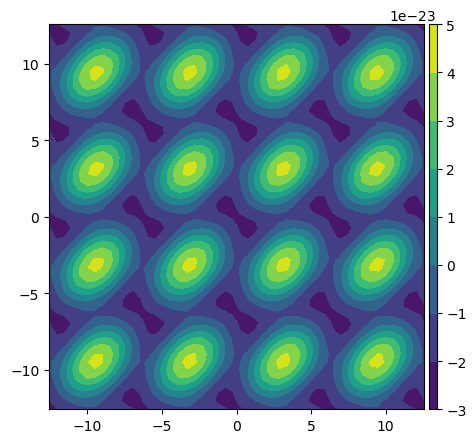

In [34]:
phi_grid = sc.Grid1d(-4*np.pi, 4*np.pi, dim)
a = fluxqubit.plot_potential(phi_grid=phi_grid);

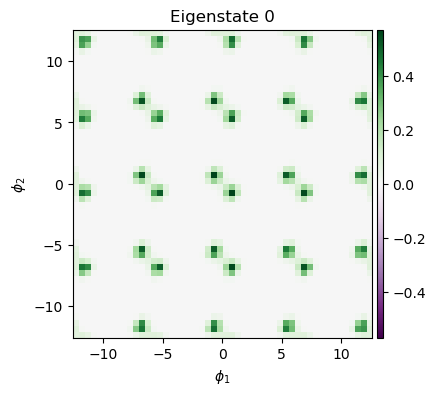

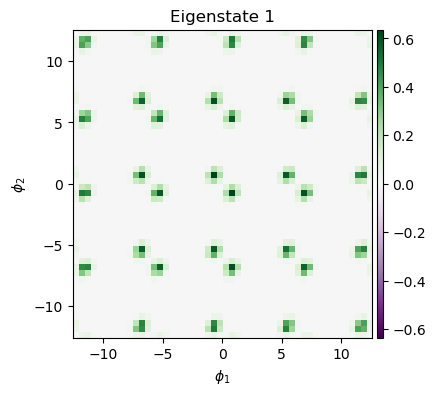

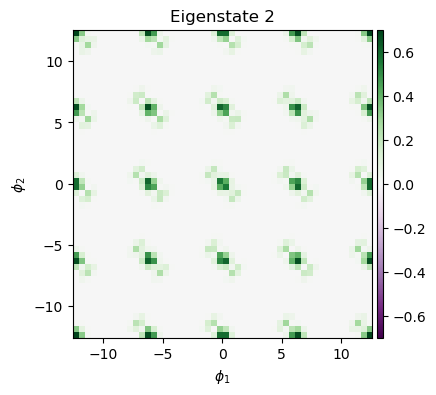

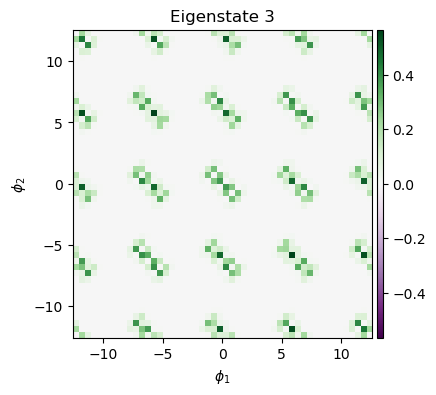

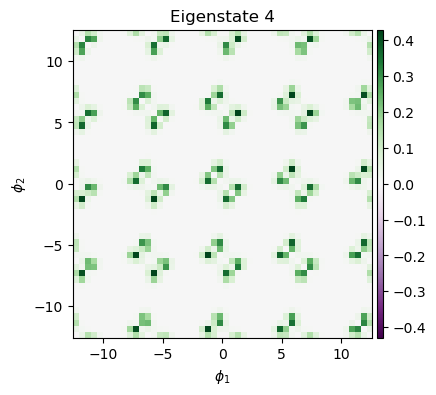

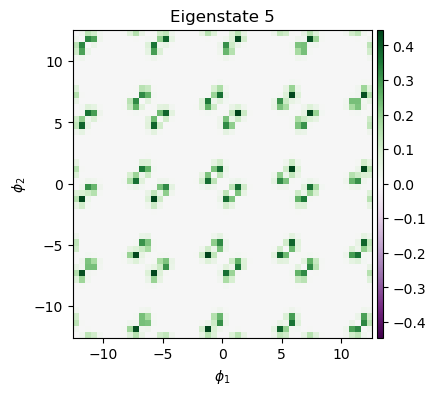

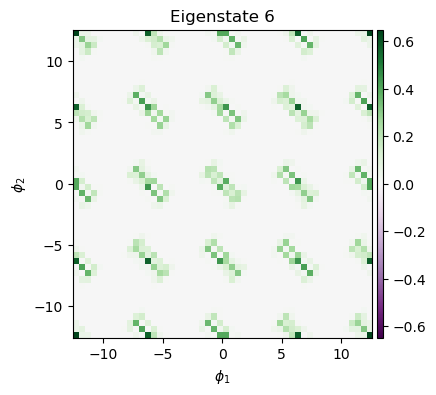

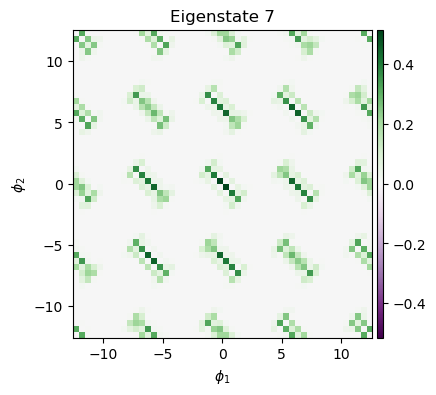

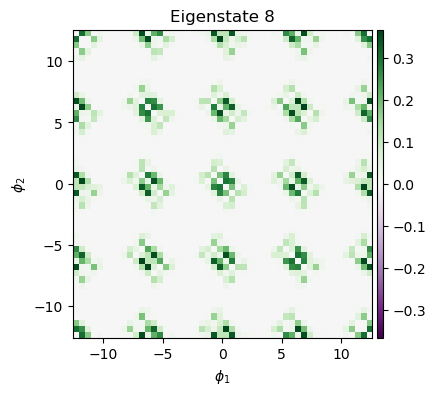

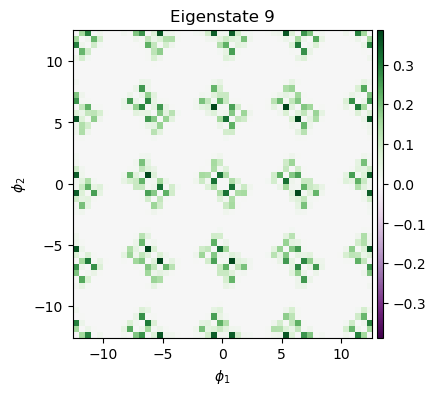

In [35]:
for n in range(10):
    fig, ax = fluxqubit.plot_wavefunction(esys=esys, which=n, phi_grid=phi_grid, mode='abs_sqr',figsize=(4,4));
    ax.set_title("Eigenstate " + str(n))
    ax.set_xlabel(r"$\phi_1$")
    ax.set_ylabel(r"$\phi_2$")
plt.show()

In [36]:
circuit.transform_charge_to_flux()
eigs = circuit.estates_in_phi_basis

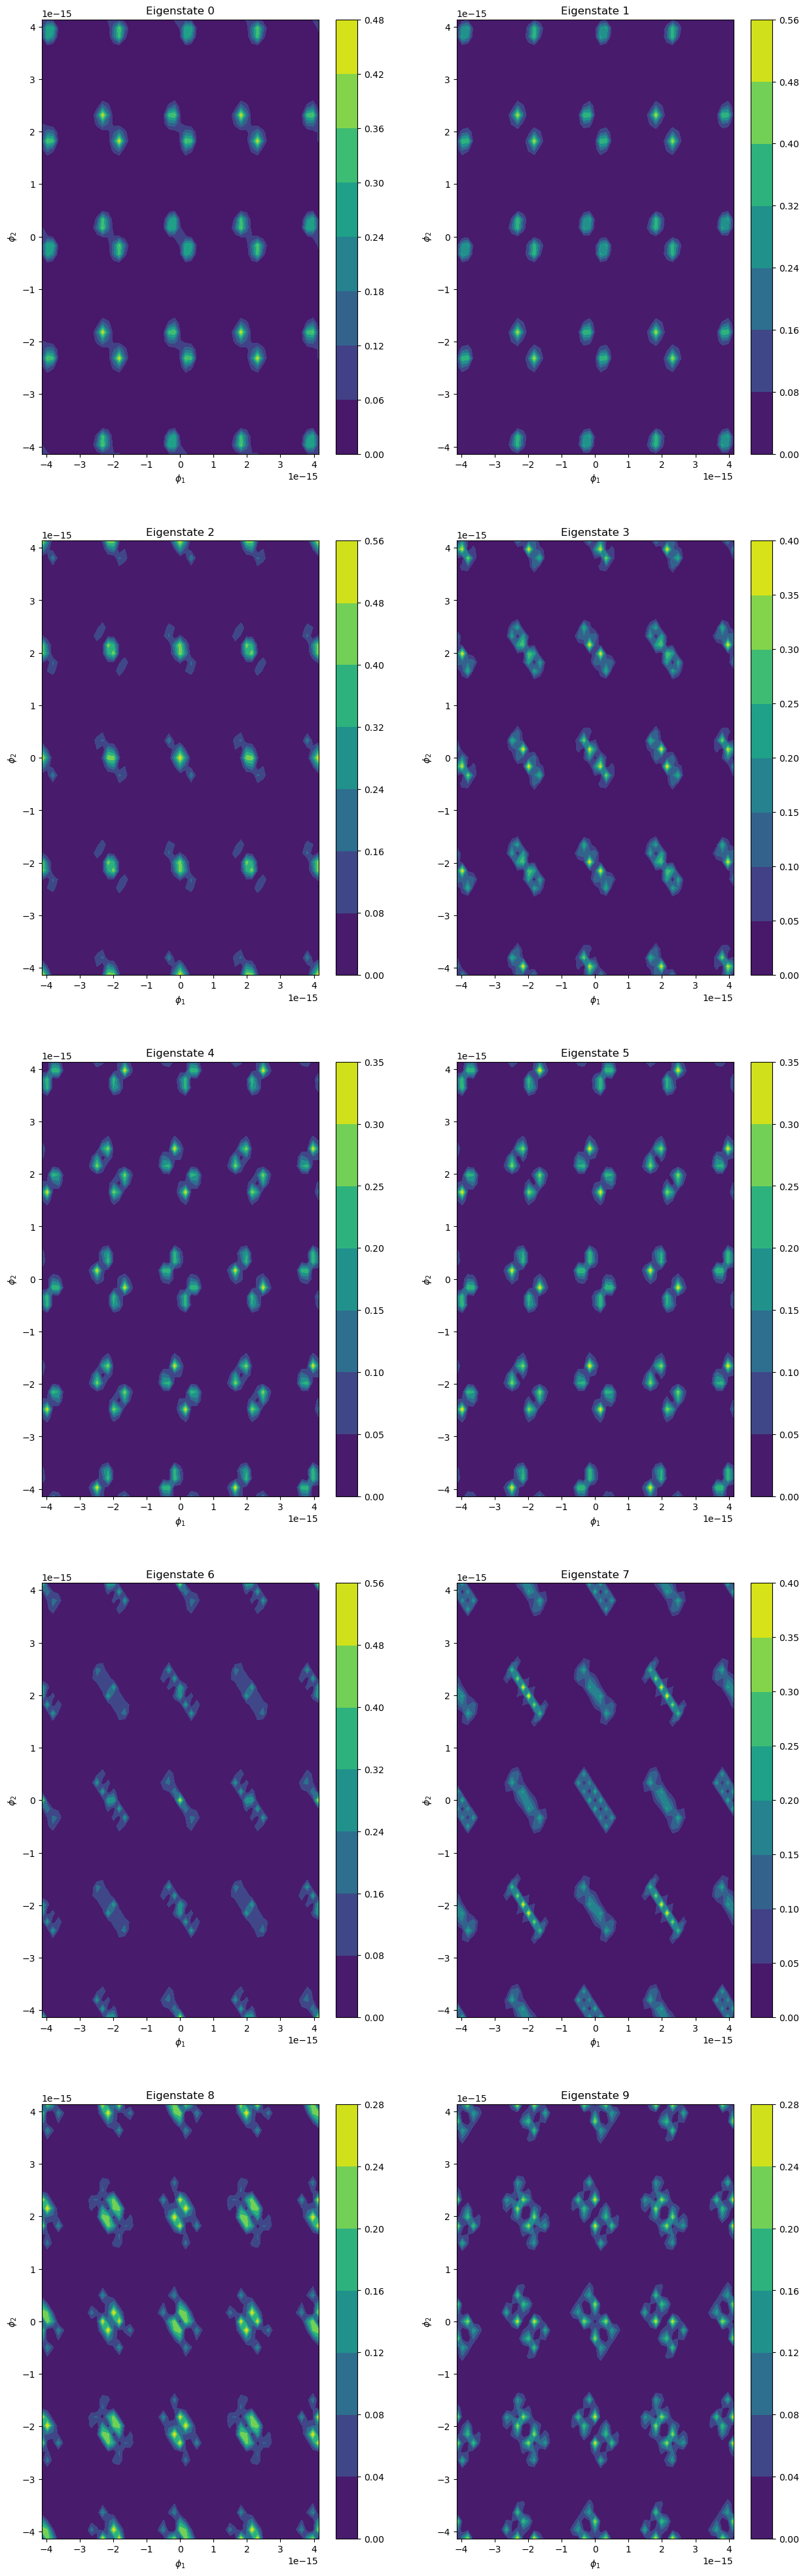

In [37]:
plt.figure(figsize=(15,50))
for n in range(10):
    plt.subplot(5,2, n+1)
    plt.contourf(circuit.flux_list, circuit.flux_list, 
                 abs(np.array(eigs[n].reshape(circuit.n_dim,circuit.n_dim)))**2)
    plt.colorbar()
    plt.title("Eigenstate " + str(n) )
    plt.xlabel(r"$\phi_1$")
    plt.ylabel(r"$\phi_2$")
plt.show()